In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shruhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = pd.read_json('/Users/shruhi/Documents/212 Project/Dataset.json', lines = True)
data = pd.DataFrame(data)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
data = data.iloc[:,1:]
print(data.shape)
data.head()

(26709, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Let's check the target variable distribution

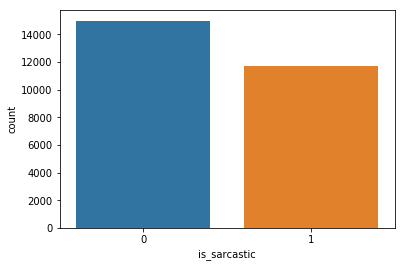

In [4]:
sns.countplot(data['is_sarcastic'])

Cleaning is done using NLTK (library for NLP), re (library for regex)

In [5]:
corpus = []
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english", ignore_stopwords=True)

for i in range(0, len(data)):
    describe = re.sub('!', 'exclamation', data['headline'][i])
    describe = describe.replace('?', 'questionmark')
    quotes = re.findall(r'\'(.+?)\'', describe)
    if quotes:
        describe += 'quotes'
    describe = re.sub('^[a-z]', ' ', describe) #remove everything except lowercase letters
    describe = describe.split()
    describe = [stemmer.stem(word) for word in describe]
    describe = ' '.join(describe)
    corpus.append(describe)

Feature creation:
Bag of words model-

By doing ‘count_vect.fit_transform(x_count.data)’, we are learning the vocabulary dictionary and it returns a Document-Term matrix of [n_samples, n_features].

In [6]:
count_v = CountVectorizer()
x_count = count_v.fit_transform(corpus).toarray()
print(x_count.shape)

(26709, 24833)


Splitting into training and testing set:

In [7]:
y = data.is_sarcastic

x_train, x_test, y_train, y_test = train_test_split(x_count, y, test_size = 0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(21367, 24833) (21367,)
(5342, 24833) (5342,)


In [8]:
def output(alg, x_test, y_test, predicted):
    conf_matrix = confusion_matrix(y_test,predicted)
    classf_report = classification_report(y_test,predicted)
    print('\nConfusion matrix\n',conf_matrix)
    print('\nClassification report\n',classf_report)
    
    TP = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TN = conf_matrix[1][1]
    error = (FP+FN)/(TP+TN+FP+FN)
    print('\nError is %.2f\n'%error)
    
def plot(alg, x_test, y_test, predicted):
    prob = alg.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, prob)
    plt.plot(fpr,tpr)

In [23]:
def naivebayes(x_train, y_train, x_test, y_test):
    alg = MultinomialNB().fit(x_train, y_train)
    predicted = alg.predict(x_test)
    accuracy = np.mean(predicted == y_test)
    print("Accuracy for Naive Bayes\n%.2f"%accuracy)
    global out
    out = {'alg':alg, 'accuracy':accuracy, 'predicted':predicted}

def logreg(x_train, y_train, x_test, y_test):
    alg = LogisticRegression().fit(x_train,y_train)
    predicted = alg.predict(x_test)
    accuracy = np.mean(predicted == y_test)
    print("Accuracy for logistic regression\n%.2f"%accuracy)
    global out
    out = {'alg':alg, 'accuracy':accuracy, 'predicted':predicted}
    
    
def sgd(x_train, y_train, x_test, y_test):
    alg = SGDClassifier(n_iter=5, random_state=42)
    alg = alg.fit(x_train, y_train)
    predicted = alg.predict(x_test)
    accuracy = np.mean(predicted == y_test)
    print("Accuracy for SGD classifier\n%.2f"%accuracy)
    global out
    out = {'alg':alg, 'accuracy':accuracy, 'predicted':predicted}
    

def ranfor(x_train, y_train, x_test, y_test):
    alg = RandomForestClassifier().fit(x_train, y_train)
    predicted = alg.predict(x_test)
    accuracy = np.mean(predicted == y_test)
    print("Accuracy for Random Forest\n%.2f"%accuracy)
    global out
    out = {'alg':alg, 'accuracy':accuracy, 'predicted':predicted}

Accuracy for Random Forest
0.84

Confusion matrix
 [[2525  394]
 [ 443 1980]]

Classification report
              precision    recall  f1-score   support

          0       0.85      0.87      0.86      2919
          1       0.83      0.82      0.83      2423

avg / total       0.84      0.84      0.84      5342


Error is 0.16



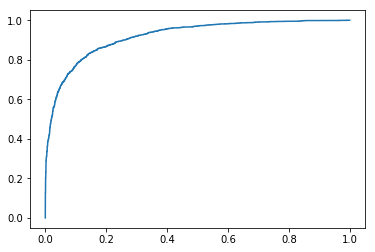

In [24]:
accuracy = {}

naivebayes(x_train, y_train, x_test, y_test)
accuracy.update({'NB': out['accuracy']})
output(out['alg'], x_test, y_test, out['predicted'])
plot(out['alg'], x_test, y_test, out['predicted'])

Accuracy for logistic regression
0.83

Confusion matrix
 [[2518  401]
 [ 504 1919]]

Classification report
              precision    recall  f1-score   support

          0       0.83      0.86      0.85      2919
          1       0.83      0.79      0.81      2423

avg / total       0.83      0.83      0.83      5342


Error is 0.17



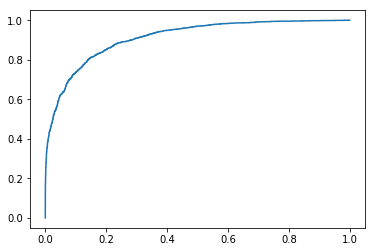

In [25]:
logreg(x_train, y_train, x_test, y_test)
accuracy.update({'LR': out['accuracy']})
output(out['alg'], x_test, y_test, out['predicted'])
plot(out['alg'], x_test, y_test, out['predicted'])

In [26]:
sgd(x_train, y_train, x_test, y_test)
accuracy.update({'SGD': out['accuracy']})
output(out['alg'], x_test, y_test, out['predicted'])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy for SGD classifier
0.82

Confusion matrix
 [[2539  380]
 [ 569 1854]]

Classification report
              precision    recall  f1-score   support

          0       0.82      0.87      0.84      2919
          1       0.83      0.77      0.80      2423

avg / total       0.82      0.82      0.82      5342


Error is 0.18



Accuracy for Random Forest
0.78

Confusion matrix
 [[2556  363]
 [ 814 1609]]

Classification report
              precision    recall  f1-score   support

          0       0.76      0.88      0.81      2919
          1       0.82      0.66      0.73      2423

avg / total       0.78      0.78      0.78      5342


Error is 0.22



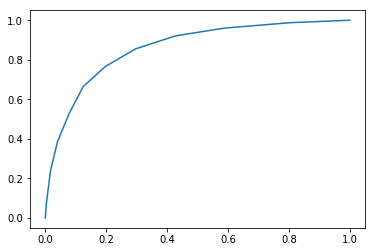

In [28]:
ranfor(x_train, y_train, x_test, y_test)
accuracy.update({'RF': out['accuracy']})
output(out['alg'], x_test, y_test, out['predicted'])
plot(out['alg'], x_test, y_test, out['predicted'])

We try to improve the model. Count the headline length into consideration and remove outliers from that.

2. Removing noise using Tfidvectorizer
Make a TF-IDF:
{Convert a collection of raw documents to a matrix of TF-IDF features.

Equivalent to CountVectorizer followed by TfidfTransformer.}

Meximum features = 3000, 5000, 10000

n-gram range: (1, 3)

In [29]:
data['length'] = data['headline'].apply(lambda x: len(x.split(" ")))
data.head()

,headline,is_sarcastic,length
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


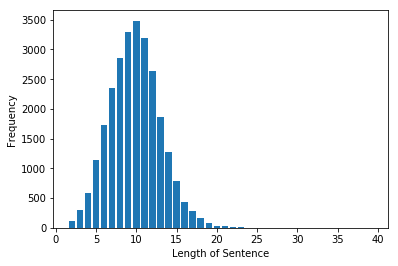

In [30]:
data_length = data['length'].value_counts().reset_index()
data_length.rename(columns={'index':'length', 'length':'frequency'}, inplace=True)
data_length.head()

fig = plt.figure()
plt.bar(data_length['length'], data_length['frequency'])
plt.xlabel('Length of Sentence')
plt.ylabel('Frequency')
fig.savefig('lengthfrqplot.jpg')

(26606, 3)


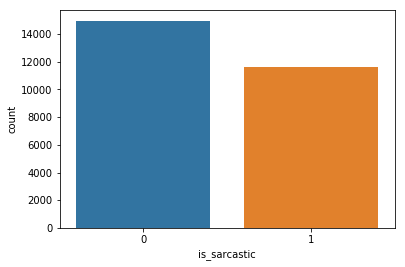

In [31]:
data = data[data['length'] < 20]
print(data.shape)
sns.countplot(data['is_sarcastic'])

In [36]:
m_feat = [3000, 5000, 10000]

for i in range(0,3):
    tf = TfidfVectorizer(analyzer = "word", ngram_range = (1,3), max_features = m_feat[i], norm ="l2")
    x_tf = tf.fit_transform(data['headline'])
    y = data.is_sarcastic
    x_train, x_test, y_train, y_test = train_test_split(x_tf, y, test_size = 0.2)
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    logreg(x_train, y_train, x_test, y_test)
    accuracy.update({'LR' + str(i) : out['accuracy']})
    sgd(x_train, y_train, x_test, y_test)
    accuracy.update({'SGD' + str(i) : out['accuracy']})
    ranfor(x_train, y_train, x_test, y_test)
    accuracy.update({'RF' + str(i): out['accuracy']})
    i+=1
    
print(accuracy)

(21284, 3000) (21284,)
(5322, 3000) (5322,)
Accuracy for logistic regression
0.84
Accuracy for SGD classifier
0.84


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy for Random Forest
0.79
(21284, 5000) (21284,)
(5322, 5000) (5322,)
Accuracy for logistic regression
0.84
Accuracy for SGD classifier
0.84


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy for Random Forest
0.80
(21284, 10000) (21284,)
(5322, 10000) (5322,)
Accuracy for logistic regression
0.85
Accuracy for SGD classifier
0.85


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy for Random Forest
0.79
{'NB': 0.8433171096967428, 'LR': 0.8305877948333957, 'SGD': 0.8223511793335829, 'RF': 0.7796705353800075, 'LR0': 0.8365276211950394, 'SGD0': 0.8387824126268321, 'RF0': 0.7908680947012401, 'LR1': 0.8385945133408493, 'SGD1': 0.8357760240511086, 'RF1': 0.8043968432919955, 'LR2': 0.8461104847801578, 'SGD2': 0.8464862833521233, 'RF2': 0.7931228861330327}


In [38]:
tf = TfidfVectorizer(analyzer = "word", ngram_range = (1,3), norm ="l2")
x_tf = tf.fit_transform(data['headline'])
y = data.is_sarcastic
x_train, x_test, y_train, y_test = train_test_split(x_tf, y, test_size = 0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
naivebayes(x_train, y_train, x_test, y_test)
accuracy.update({'NB1': out['accuracy']})

(21284, 373526) (21284,)
(5322, 373526) (5322,)
Accuracy for Random Forest
0.79


In [39]:
accuracy_df = pd.DataFrame.from_dict(accuracy, orient = 'index', columns= ['Accuracy'])
accuracy_df.reset_index(level=0, inplace=True)
print(accuracy_df)

   index  Accuracy
0     NB  0.843317
1     LR  0.830588
2    SGD  0.822351
3     RF  0.779671
4    LR0  0.836528
5   SGD0  0.838782
6    RF0  0.790868
7    LR1  0.838595
8   SGD1  0.835776
9    RF1  0.804397
10   LR2  0.846110
11  SGD2  0.846486
12   RF2  0.793123
13   NB1  0.793687


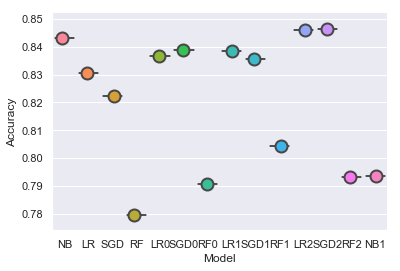

In [40]:
fig = plt.figure()
sns.set()
sns.boxplot(x='index', y='Accuracy', data=accuracy_df)
sns.stripplot(x='index', y='Accuracy', data=accuracy_df,
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.xlabel("Model")
sns.despine()
plt.show()
fig.savefig("Model Accuracy.jpg")